In [1]:
import scipy.io
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.spatial import distance
from geopy.distance import geodesic
import geopy.point as point
from tools import *
from pylab import *

In [2]:
london_20 = 'london_square'
paris_20 = 'paris_square_20'

In [3]:
meta_ld, cirs_ld, _, Y_all_ld, RX_all_ld, _, _ = read_mat(london_20)
meta_pr, cirs_pr, _, Y_all_pr, RX_all_pr, _, _ = read_mat(paris_20)

In [11]:
ext_ld = Extractor(cirs_ld)
ext_pr = Extractor(cirs_pr)


# X_ld = ext_ld.formatting_X()
# X_pr = ext_pr.formatting_X()

X_ld = ext_ld.amplitute_feature()
X_pr = ext_pr.amplitute_feature(ext_ld.max_reflection)

d:\Telecom_2eme_anne\Geolocation_simulation\Simulation\tools.py:94: ComplexWarning: Casting complex values to real discards the imaginary part
  self.mag = - math.floor(math.log(np.mean(self.delay_set), 10))


In [12]:
ext_ld.max_reflection, ext_pr.max_reflection,X_ld.shape, X_pr.shape

(5, 4, (400, 125), (400, 125))

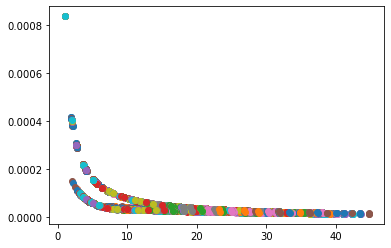

In [6]:
cir_profile = cirs_ld

T, S = cir_profile.shape

x_pre = []
for j in range(T):
    cir_t = [] # channel impulse response for a transmitter
    for i in range(S):
        c_tmp = cir_profile[j, i].copy()
        c_tmp[0, :] = c_tmp[0, :] * 10 ** 7 # normalize the delay seconds
        
        m, n = c_tmp.shape
        if m == 2:
            c_tmp[1, :] = abs(c_tmp[1, :])
        plt.scatter(c_tmp[0, :], c_tmp[1, :])

In [16]:
c_tmp
x_in = np.ones((10))
np.convolve(c_tmp[0, :], x_in)

array([ 5.10129407+0.j, 12.40345748+0.j, 19.705594  +0.j, 19.705594  +0.j,
       19.705594  +0.j, 19.705594  +0.j, 19.705594  +0.j, 19.705594  +0.j,
       19.705594  +0.j, 19.705594  +0.j, 14.60429993+0.j,  7.30213652+0.j])

In [17]:
from sklearn.neighbors import KernelDensity

In [ ]:
kde = KernelDensity(kernel='gaussian').fit(np.real(c_tmp))

x = np.linspace(0, 20, 3)
plt.plot(x, kde.score_samples(x.reshape(1, -1)))

d:\Users\lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\collections.py:153: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


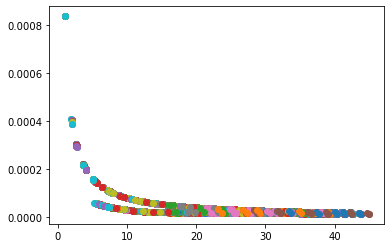

In [8]:
cir_profile = cirs_pr

T, S = cir_profile.shape

x_pre = []
for j in range(T):
    cir_t = [] # channel impulse response for a transmitter
    for i in range(S):
        c_tmp = cir_profile[j, i].copy()
        c_tmp[0, :] = c_tmp[0, :] * 10 ** 7 # normalize the delay seconds
        
        m, n = c_tmp.shape
        if m == 2:
            c_tmp[1, :] = abs(c_tmp[1, :])
        plt.scatter(c_tmp[0, :], c_tmp[1, :])

d:\Users\lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\lib\histograms.py:852: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
d:\Users\lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\transforms.py:789: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)
d:\Users\lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\transforms.py:1969: ComplexWarning: Casting complex values to real discards the imaginary part
  x, y = float(x), float(y)


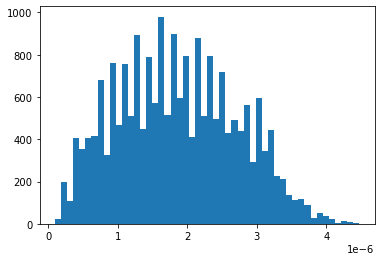

In [38]:
_ = plt.hist(ext_ld.delay_set, bins=50)

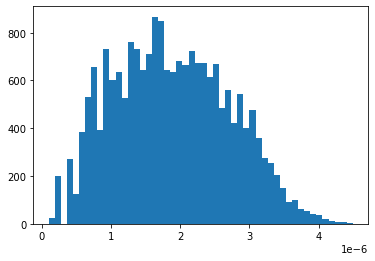

In [39]:
_ = plt.hist(ext_pr.delay_set, bins=50)

In [6]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, mean_squared_error
from sklearn.model_selection import cross_val_score, cross_validate
from tqdm import tqdm
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.tree import DecisionTreeRegressor as DT
from sklearn.pipeline import Pipeline
import seaborn as sns
import lightgbm as lgb

In [7]:
xgb_pipe = Pipeline([('scale', StandardScaler()), \
    ('xgb', MultiOutputRegressor(xgb.XGBRegressor(n_estimators=500, max_depth=2000, eta=0.1, subsample=1, colsample_bytree=1, reg_lambda=0)))])

lgb_pipe = Pipeline([('scale', StandardScaler()), \
    ('lgb', MultiOutputRegressor(lgb.LGBMRegressor(n_estimators=500, max_depth=2000, eta=0.1, subsample=1, colsample_bytree=1, reg_lambda=0)))])

rf_pipe = Pipeline([('scale', StandardScaler()), ('rf', RF(max_depth=2000))])

dt_pipe = Pipeline([('scale', StandardScaler()), ('dt', DT(max_depth=2000))])

In [8]:
pipes = [xgb_pipe, lgb_pipe, rf_pipe, dt_pipe]
model_ls = ['XGB', 'LGBM', 'RF', 'DT']

In [43]:
Y_all_ld.shape, RX_all_ld.shape, cirs_ld.shape

((400, 2), (25, 2), (400, 25))

In [9]:
pf_ld = PipesFitting(X_ld, Y_all_ld, RX_all_ld)
pf_ld.add_pipes(pipes, model_ls)
pf_ld.fit()

[LightGBM] [Warning] learning_rate is set=0.1, eta=0.1 will be ignored. Current value: learning_rate=0.1


In [14]:
pr_pred = pf_ld.model_all[1].predict(X_pr)

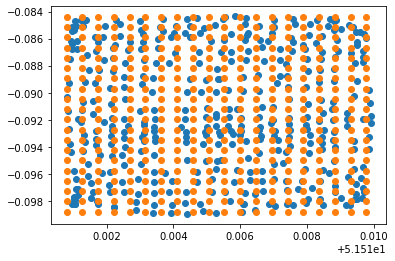

In [16]:
plot_agent(pf_ld.model_all[1].predict(X_pr))
plot_agent(Y_all_ld)
# plot_agent(Y_all_pr)
# plot_agent(Y_all_ld)